In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv("/home/haruk/workspace/ml-workspace-202507/math/math_data/ogikubo_oneroom_train.csv")


In [2]:
data.head()

,name,value,area,age,distance,bath_toilet_separated,autolock
0,フェリーチェ上井草A,6.0,15.12,0,15,1,1
1,メゾン・ド・荻窪,4.5,12.11,40,7,0,0
2,ＪＲ中央線 荻窪駅 3階建 築40年,4.5,12.11,40,6,0,0
3,フェリーチェ上井草A,6.3,15.12,0,15,1,1
4,グローリア初穂阿佐ヶ谷,6.0,16.65,31,15,0,1


In [3]:
data.columns

Index(['name', 'value', 'area', 'age', 'distance', 'bath_toilet_separated',
       'autolock'],
      dtype='object')

In [4]:
feature_name = ['area', 'age', 'distance', 'bath_toilet_separated','autolock']
X_train = data[feature_name].values
y_train = data["value"].values

In [5]:
#勾配ブースティング
gbr = GradientBoostingRegressor(
    learning_rate=0.01,
    n_estimators=1000,
    max_leaf_nodes=4,
    min_samples_leaf = 10
)
gbr.fit(X_train,y_train)

,loss,'squared_error'
,learning_rate,0.01
,n_estimators,1000
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [6]:
test_data = pd.read_csv("/home/haruk/workspace/ml-workspace-202507/math/math_data/ogikubo_oneroom_test.csv")
X_test = test_data[feature_name].values
y_test = test_data["value"].values

In [7]:
pred_train = gbr.predict(X_train)
pred_test = gbr.predict(X_test)

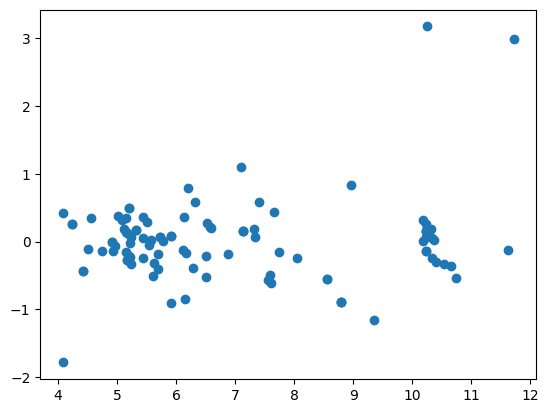

In [9]:
#残差プロット
error_train = y_train - pred_train
plt.scatter(pred_train,error_train)
plt.show()

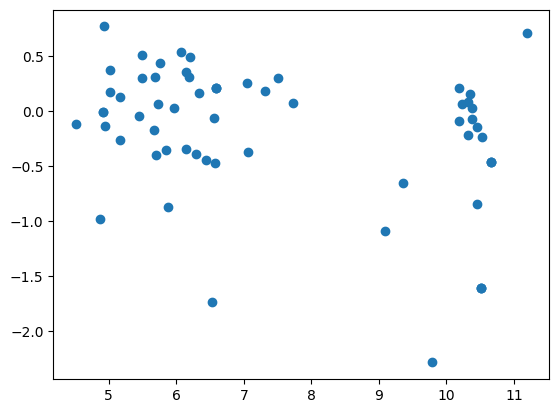

In [10]:
error_test = y_test - pred_test
plt.scatter(pred_test,error_test)
plt.show()

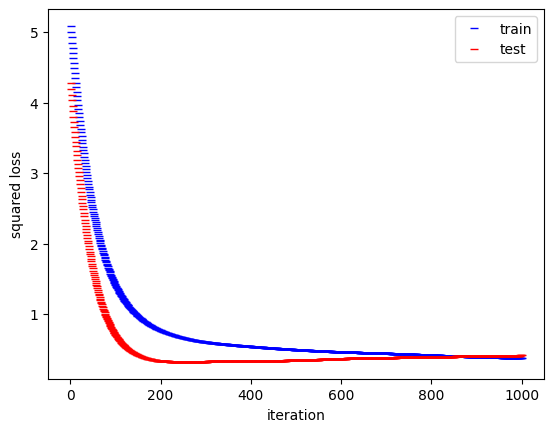

In [13]:
# 学習曲線

max_iteration = 1000
test_score = np.zeros(max_iteration,dtype=np.float64)

for i ,pred_test in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = np.mean((y_test - pred_test) ** 2)

plt.plot(np.arange(max_iteration) + 1,gbr.train_score_,"b_",label="train")
plt.plot(np.arange(max_iteration) + 1,test_score,"r_",label="test")
plt.xlabel("iteration")
plt.ylabel("squared loss")
plt.legend()
plt.show()

In [16]:
# early stopping

from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(learning_rate=0.01,
                                n_estimators=1000,
                                max_depth=None,
                                max_leaf_nodes=4,
                                min_samples_leaf=10,
                                n_iter_no_change=5,
                                validation_fraction=0.2)
gbr.fit(X_train,y_train)

,loss,'squared_error'
,learning_rate,0.01
,n_estimators,1000
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_depth,None
,min_impurity_decrease,0.0
,init,None


In [17]:
gbr.train_score_.shape#453回でstop

(453,)

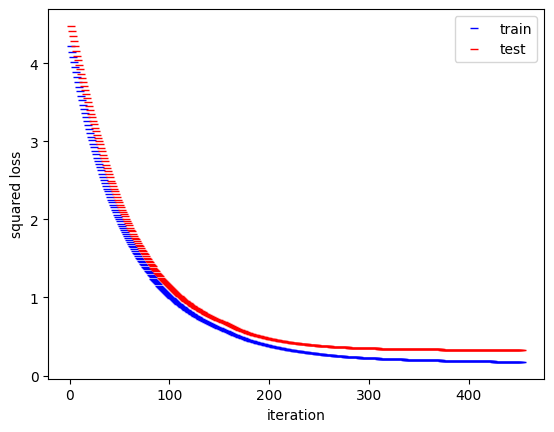

In [20]:
# 学習曲線
max_iteration=453
test_score = np.zeros(max_iteration,dtype=np.float64)

for i,pred_test in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = np.mean((y_test - pred_test) **2)

plt.plot(np.arange(max_iteration) + 1,gbr.train_score_,"b_",label="train")
plt.plot(np.arange(max_iteration) + 1,test_score,"r_",label="test")
plt.xlabel("iteration")
plt.ylabel("squared loss")
plt.legend()
plt.show()

- 過剰適合が抑えられる

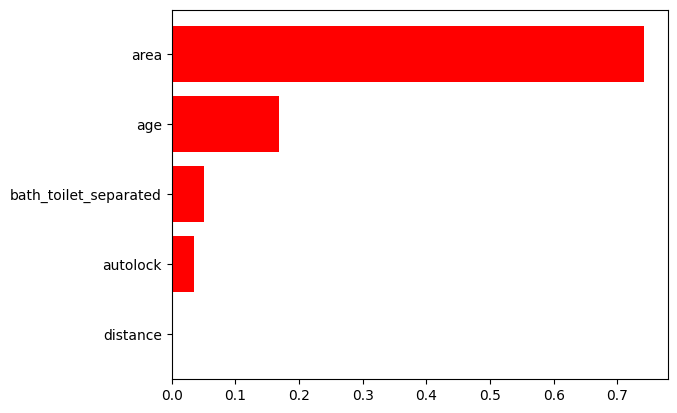

In [21]:
# 変数重要度
importances = gbr.feature_importances_
indices = np.argsort(importances)
plt.barh(np.asarray(feature_name)[indices],importances[indices],
         color="r",align="center")
plt.show()

In [23]:
indices,importances

(array([2, 4, 3, 1, 0]),
 array([0.74160974, 0.16870455, 0.00258402, 0.05145693, 0.03564476]))

In [24]:
#勾配ブースティング
gbr = GradientBoostingRegressor(
    learning_rate=0.01,
    n_estimators=1000,
    max_leaf_nodes=4,
    min_samples_leaf = 10
)

In [26]:
from sklearn.model_selection import cross_val_score
import optuna

/home/haruk/workspace/ml-workspace-202507/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate",0.001,1,log=True)
    n_estimators = trial.suggest_int("n_eatimators",100,2000)
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes",2,64)
    min_sample_leaf = trial.suggest_int("min_sample_nodes",1,50)

    gbr = GradientBoostingRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_leaf_nodes=max_leaf_nodes,
        min_samples_leaf=min_sample_leaf,
        random_state=42

    )

    score = cross_val_score(
        gbr,X_train,y_train,scoring="neg_root_mean_squared_error",
        cv=5
    )

    return score.mean()


In [29]:
study = optuna.create_study(direction="minimize")
study.optimize(objective,n_trials=50)

[I 2025-09-17 11:30:28,143] A new study created in memory with name: no-name-56e0d073-718b-4a9a-9798-4dc22b8e8bba
[I 2025-09-17 11:30:30,359] Trial 0 finished with value: -0.9401541587157196 and parameters: {'learning_rate': 0.790891853252971, 'n_eatimators': 1570, 'max_leaf_nodes': 47, 'min_sample_nodes': 2}. Best is trial 0 with value: -0.9401541587157196.
[I 2025-09-17 11:30:30,702] Trial 1 finished with value: -2.2768203389790447 and parameters: {'learning_rate': 0.3048563030146377, 'n_eatimators': 285, 'max_leaf_nodes': 32, 'min_sample_nodes': 46}. Best is trial 1 with value: -2.2768203389790447.
[I 2025-09-17 11:30:33,033] Trial 2 finished with value: -1.6237340601339016 and parameters: {'learning_rate': 0.9756235005488338, 'n_eatimators': 1854, 'max_leaf_nodes': 6, 'min_sample_nodes': 28}. Best is trial 1 with value: -2.2768203389790447.
[I 2025-09-17 11:30:34,695] Trial 3 finished with value: -0.954911577155914 and parameters: {'learning_rate': 0.004087990019540892, 'n_eatimato